# CS4320 Introduction to Machine Learning

## A Template for the Course Project Submssion

Note: This template is optional. You can design your Jupyter Notebook structure based on your competition and preference. However, we expect you practice as many machine learning skills you learned in this course as possible.

**Please type your group name here:**

In [1]:
GroupName = "OceanGate"
assert GroupName != "", 'Please enter your name in the above quotation marks, thanks!'

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Submit the predictions to Kaggle](#13)
14. [Your takeaway from the course](#14)

## Submission instructions <a name="si"></a>
<hr>

- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- Upload the .ipynb file to Canvas.
- **Submit the screenshot of your Kaggle submission ranking and score** 
- Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
- Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
- Make sure that the plots and output are rendered properly in your submitted file. 
- Please keep your notebook clean and delete any throwaway code.

## Introduction <a name="in"></a>

A few notes and tips when you work on this project: 

#### Tips
1. The project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


## Setup

In [2]:
# Sklearn stuff
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Other
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import chi2_contingency


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<!-- BEGIN QUESTION -->

## Pick your problem and explain the prediction problem <a name="1"></a>
---

We've opted for the [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) competition, which aims to predict passenger survival based on 10 key features:
- Pclass: Ticket class, represents socio-economic status
    - 1 = Upper class
    - 2 = Middle class
    - 3 = Lower class
- Name
- Sex
- Age
- SibSp: Number of siblings and/or spouses aboard
- Parch: Number of parents and/or children aboard
- Ticket: Ticket number
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Port of embarkation
    - (C)herbourg
	- (Q)ueenstown
	- (S)outhampton

With 891 entries in the training set and 418 in the test set, the challenge is to leverage machine learning techniques to predict survival (boolean "Survived" column) for the test set, absent in the provided data. The "Survived" column serves as our target variable, with 0 indicating non-survival.

One noteworthy observation is the potential utility of the "Name" feature for extracting titles, offering insights into social status. However, challenges arise, such as the significant number of missing values in the "Cabin" feature. Addressing these gaps will be crucial for robust model performance.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Data splitting <a name="2"></a>
---

In [3]:
# test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
# train_df = pd.read_csv('/kaggle/input/titanic/train.csv')

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## EDA <a name="3"></a>
---

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


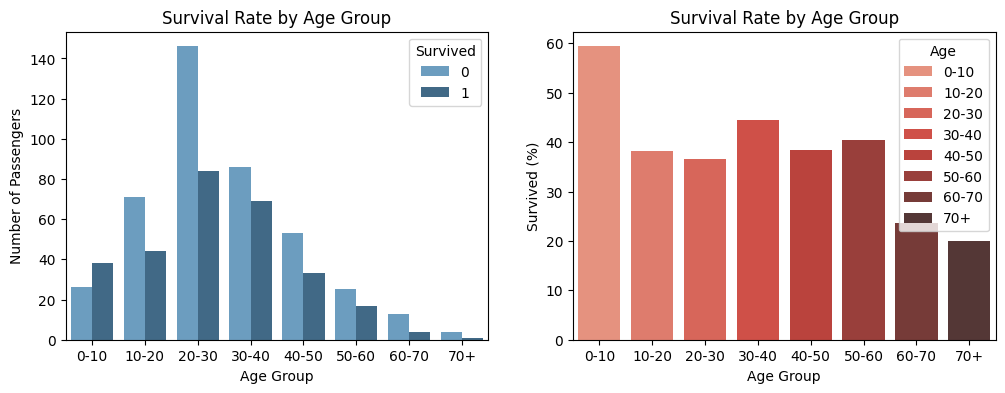

In [5]:
num_bins = 8
bins = np.linspace(0, train_df['Age'].max(), num_bins+1)
bins[-1] = np.inf
age_group_labels = [
    f"{int(i)}-{int(j)}"
    if j != np.inf
    else f"{int(i)}+"
    for i, j in zip(bins[:-1], bins[1:])
]
age_groups = pd.cut(train_df["Age"], bins=bins, labels=age_group_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(
    x=age_groups, data=train_df,
    palette="Blues_d", hue="Survived",
)
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')

plt.subplot(1, 2, 2)
sns.barplot(
    x=age_groups, y=train_df['Survived'],
    palette="Reds_d", hue=age_groups,
    estimator=lambda x: sum(x) / len(x) * 100 if len(x) > 0 else 0,
    errorbar=None
)
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survived (%)')

plt.show()

Different age groups are showing very different survival rates:
- The age group 0-10 has the highest survival rate by far
- The age groups from 10-60 show roughly the same survival rates
- The age groups above 60 show very low survival rates.

Let's see if these differences in survival rates are actually significant:

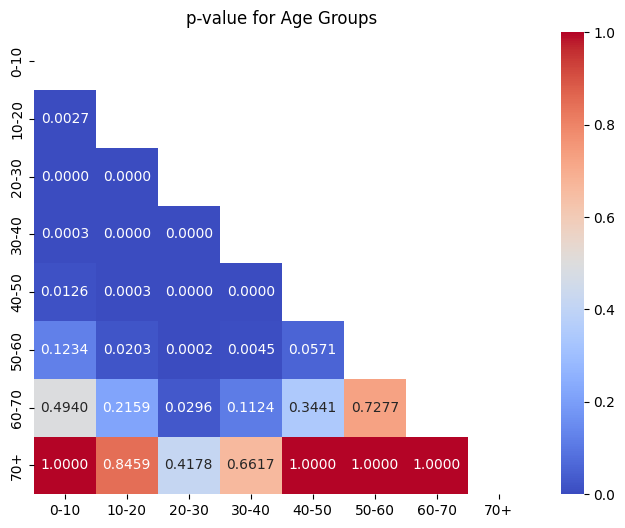

In [6]:
# Idea from: https://medium.com/analytics-vidhya/constructing-heat-map-for-chi-square-test-of-independence-6d78aa2b140f

p_values = np.zeros((num_bins, num_bins))
for i, group1 in enumerate(age_group_labels):
    for j, group2 in enumerate(age_group_labels):
        contingency_table = pd.crosstab(
            age_groups == group1,
            age_groups == group2
        )
        _, p_values[i, j], _, _ = chi2_contingency(contingency_table)
        
mask = np.triu(np.ones_like(p_values, dtype=bool))
plt.figure(figsize=(8, 6))

sns.heatmap(
    p_values, annot=True, fmt='.4f', mask=mask,
    xticklabels=age_group_labels, yticklabels=age_group_labels,
    cmap='coolwarm',
)

plt.title('p-value for Age Groups')
plt.show()

This test tells us that the difference we see in survival rate between 70+
year olds and every other group is not significant.

However, the difference in survival rates between most other groups seems
significant, as many of them have p-values below 0.05.

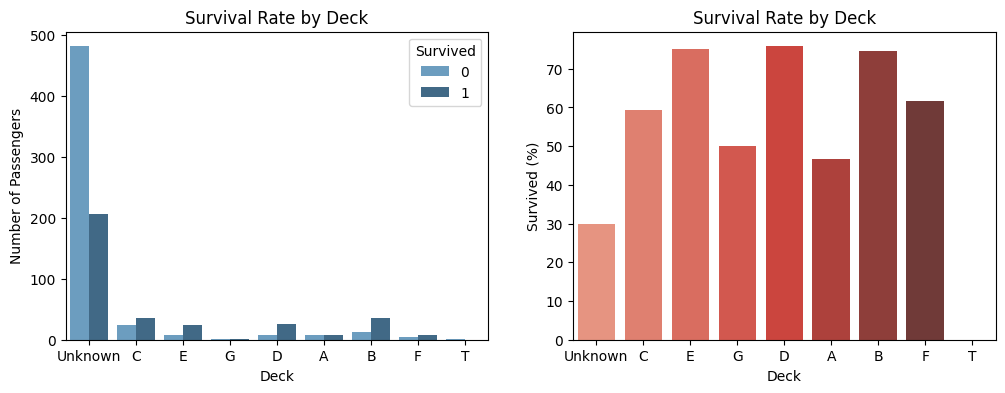

In [7]:
decks = train_df["Cabin"].str[0].fillna('Unknown')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(
    x=decks, data=train_df,
    palette="Blues_d", hue="Survived",
)
plt.title('Survival Rate by Deck')
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')

plt.subplot(1, 2, 2)
sns.barplot(
    x=decks, y=train_df['Survived'],
    palette="Reds_d", hue=decks,
    estimator=lambda x: sum(x) / len(x) * 100 if len(x) > 0 else 0,
    errorbar=None
)
plt.title('Survival Rate by Deck')
plt.xlabel('Deck')
plt.ylabel('Survived (%)')

plt.show()

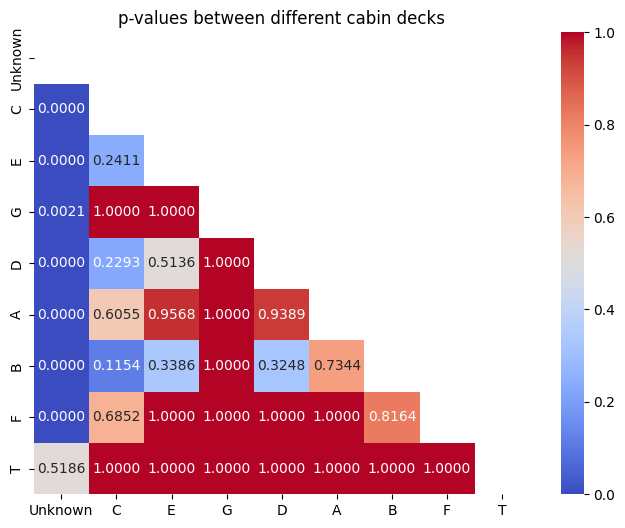

In [8]:
# Idea from: https://medium.com/analytics-vidhya/constructing-heat-map-for-chi-square-test-of-independence-6d78aa2b140f

deck_names = decks.unique()
p_values = np.zeros((len(deck_names), len(deck_names)))
for i, deck1 in enumerate(deck_names):
    for j, deck2 in enumerate(deck_names):
        contingency_table = pd.crosstab(
            decks == deck1,
            decks == deck2,
        )
        _, p_values[i, j], _, _ = chi2_contingency(contingency_table)
        
plt.figure(figsize=(8, 6))
sns.heatmap(
    p_values, annot=True, fmt=".4f", cmap="coolwarm", 
    xticklabels=deck_names, yticklabels=deck_names,
    mask=np.triu(np.ones_like(p_values, dtype=bool)),
)
plt.title("p-values between different cabin decks")
plt.show()

We can see from this heatmap that the differences in survival rate between the
"unknown" cabin group and the other groups are very significant. This is important
to note, as we otherwise may have just dropped the "Cabin" column due to the large
number of missing values.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Feature engineering <a name="4"></a>
<hr>

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set. You may have to go back and forth between feature engineering and preprocessing.

In [9]:
# Having more family members on board might have made it harder to escape the sinking ship
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

# Being alone may have made it easier to escape the sinking ship
train_df["IsAlone"] = train_df["FamilySize"] == 1
test_df["IsAlone"] = test_df["FamilySize"] == 1

# Title may signify social status, which may affect the survival rate.
train_df["Title"] = train_df["Name"].str.extract(r" ([A-Za-z]+)\.")
test_df["Title"] = test_df["Name"].str.extract(r" ([A-Za-z]+)\.")

# As we saw earlier, age group is a good indicator of survival rate
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
train_df["AgeGroup"] = pd.cut(train_df["Age"], bins=bins, labels=age_group_labels)
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
test_df["AgeGroup"] = pd.cut(test_df["Age"], bins=bins, labels=age_group_labels)

train_df["IsChild"] = train_df["Age"] < 15
test_df["IsChild"] = test_df["Age"] < 15

train_df["IsOld"] = train_df["Age"] > 70
test_df["IsOld"] = test_df["Age"] > 70

# We can also use the deck as an indicator of survival rate as we saw earlier
train_df["IsUnknownDeck"] = train_df["Cabin"].str[0].isna()
test_df["IsUnknownDeck"] = test_df["Cabin"].str[0].isna()

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeGroup,IsChild,IsOld,IsUnknownDeck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,False,Mr,20-30,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,False,Mrs,30-40,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,True,Miss,20-30,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,False,Mrs,30-40,False,False,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,True,Mr,30-40,False,False,True


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Preprocessing and transformations <a name="5"></a>
<hr>

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [10]:
numeric_features = ["Fare", "FamilySize"]
binary_features = ["IsAlone", "Sex", "IsChild", "IsOld", "IsUnknownDeck"]
categorical_features = ["Embarked", "Pclass", "Title", "AgeGroup"]
drop_features = ["Age", "PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]

X = train_df.drop(columns=["Survived"])
y = train_df["Survived"]

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="if_binary"),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [11]:
# Stolen from HW3
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Dummy model <a name="6"></a>
<hr>

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

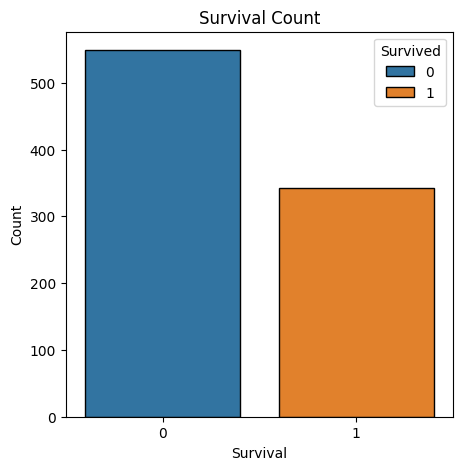

In [12]:
plt.figure(figsize=(5, 5))
sns.countplot(x='Survived', data=train_df, hue="Survived", edgecolor='black')
plt.title('Survival Count')
plt.xlabel('Survival')
plt.ylabel('Count')
plt.show()

Based on this, we know that the dummy will always predict 0.

In [13]:
results_dict = {}

dummy = DummyClassifier(strategy="most_frequent")
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X, y, return_train_score=True
)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.002),0.616 (+/- 0.003),0.616 (+/- 0.001)


In [14]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
predicted = dummy_clf.predict(test_df)

dummy_submit_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predicted})
dummy_submit_df.to_csv('dummy_submission.csv', index=False)
dummy_submit_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Models <a name="8"></a>
<hr>

**Your tasks:**
1. Try other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
dt = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier(n_neighbors=10)
knn20 = KNeighborsClassifier(n_neighbors=20)
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rfOptimized = RandomForestClassifier(max_depth=8, n_estimators=18)
svm = SVC()
vote = VotingClassifier(estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('svm', svm)], voting='hard')
lr = LinearRegression()
models = { # Arbitrary hyperparameters, for now
    "decision_tree": dt,
    "KNN": knn,
    "KNN20": knn20,
    "random_forest": rf,
    "SVM": svm,
    "voting" : vote,
    "LinearRegression": lr,
    "rfOptimized": rfOptimized
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[name] = mean_std_cross_val_scores(
        pipe, X, y, return_train_score=True
    )
    pipe.fit(X, y)
    predicted = pipe.predict(test_df)
    submit_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predicted})
    submit_df.to_csv(f'{name}_submission.csv', index=False)

pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.002),0.616 (+/- 0.003),0.616 (+/- 0.001)
decision_tree,0.027 (+/- 0.003),0.011 (+/- 0.002),0.802 (+/- 0.021),0.851 (+/- 0.009)
KNN,0.017 (+/- 0.004),0.065 (+/- 0.092),0.817 (+/- 0.016),0.834 (+/- 0.006)
KNN20,0.016 (+/- 0.001),0.023 (+/- 0.001),0.820 (+/- 0.017),0.830 (+/- 0.005)
random_forest,0.031 (+/- 0.005),0.009 (+/- 0.002),0.791 (+/- 0.032),0.819 (+/- 0.025)
SVM,0.026 (+/- 0.001),0.010 (+/- 0.001),0.838 (+/- 0.029),0.844 (+/- 0.007)
voting,0.051 (+/- 0.008),0.033 (+/- 0.004),0.824 (+/- 0.027),0.850 (+/- 0.006)
LinearRegression,0.027 (+/- 0.008),0.009 (+/- 0.001),0.397 (+/- 0.078),0.460 (+/- 0.015)
rfOptimized,0.047 (+/- 0.003),0.009 (+/- 0.001),0.819 (+/- 0.034),0.896 (+/- 0.011)


_Type your answer here, replacing this text._

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>

**Your tasks:**

Make some attempts to select relevant features. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it. 

In [16]:
# Your code here

We have done feature selection when we did feature engineering and engineered the features that we wanted to drop into more relevant features

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In [17]:
# Your code here
from sklearn.model_selection import GridSearchCV


#This takes a while, so run it if needed but I got the best params for the random forest classifier in the optmized model
# randomForestOpt = RandomForestClassifier()
# pipeline = make_pipeline(preprocessor, randomForestOpt)
# gs_rf = GridSearchCV(pipeline, param_grid={'randomforestclassifier__n_estimators': range(1, 50), 'randomforestclassifier__max_depth': range(1, 10)}, cv=5, scoring='accuracy')
# gs_rf.fit(X, y)
# gs_rf.best_params_

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="11"></a>
<hr>

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [18]:
# This import breaks on my machine 
#import eli5 
# eli5.show_weights(rfOptimized, feature_names = preprocessor.transformers_[2][1].named_steps['onehotencoder'].get_feature_names())

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (C:\Users\layto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\metaestimators.py)

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

**Your tasks:**

1. Try your best performing model on the test data (from train test split) and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

In [22]:
# Your code here



[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In our case the data was split for us, so we used all the training data then got our test data scores when submitting to kaggle. The best we got was from 0.77 percent. The best we got from cross validation testing was around 0.83 so its not that far off.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Submit the predictions to Kaggle <a name="12"></a>
<hr>

**Your tasks:**

Retrain the best model on the whole training dataset and upload the predicted output on the test set to Kaggle. Report your final test score.

In [ ]:
# Your code here



[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


All our models are trained on the full test set, with the exemption of the cross validation testing we did. We got a score of 0.77 or 77%

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="14"></a>
<hr>

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

The biggest takeway I have learned from machine learning is varied it is. Models can be fairly simple to incredibly complex and hard to understand. It was also interesting to see the current research problems behind understanding why models make the decisions that they do. To improve our model we could get a better tuned voting ensemble. 

<!-- END QUESTION -->

<br><br>